<a href="https://colab.research.google.com/github/ddiestra/avila-dataset/blob/master/Comparaci%C3%B3n_de_Modelos_Selecci%C3%B3n_de_Caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Comparación de Modelos  

###Lectura de la Data

In [1]:
                                import urllib.request
                                import zipfile, urllib.request, shutil
                                from __future__ import absolute_import, division, print_function, unicode_literals


                                url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00577/codon_usage.csv.zip'
                                filename = 'codon_usage.csv.zip'

In [2]:
with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(filename) as zf:
        zf.extractall()

In [3]:
!unzip codon_usage.csv

Archive:  codon_usage.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  codon_usage.csv.zip
replace codon_usage.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [66]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
labelencoder = LabelEncoder()

In [93]:
#Lectura del dataset
file_name = "codon_usage.csv"
dataset = pd.read_csv(file_name,  header=None)
# Eliminando columnas inválidas
columns = dataset.iloc[0]
dataset.columns = columns
dataset = dataset.drop([0],axis=0)

cols = dataset.columns[dataset.dtypes.eq(object)] # Seleccionamos las columnas con el tipo de datao : Object
dataset = dataset[cols].apply(pd.to_numeric, errors='ignore') #se transforma

# Se observa que hay datos str que no permiten manipular los demás como numéricos, por lo tanto se va a forzar.
dataset[['UUU', 'UUC']] = dataset[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
null_percentages = dataset['UUU'].isna().sum()
null_percentages



2

In [103]:
def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy()

  numeric_columns = list()
  preprocessed_dataset = preprocessed_dataset.drop("SpeciesID", axis=1)
  label_encoder = LabelEncoder()

  for column in preprocessed_dataset.columns:
    if not pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      preprocessed_dataset[column] = label_encoder.fit_transform(preprocessed_dataset[column])
    else:
     
     numeric_columns.append(column)   
     #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
     median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()
     preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)
      #print("Para la columna '{}', la codificación fue: {}".format(column, dict(enumerate(label_encoder.classes_))))  
  
  return preprocessed_dataset

In [104]:
preprocessed_dataset = preprocess_dataset(dataset)


In [105]:
labelencoder = LabelEncoder()
labelencoder.fit(preprocessed_dataset['Kingdom']);
Y1 = labelencoder.transform(preprocessed_dataset["Kingdom"]) #Leemos la data de prueba y usamos un encoder para las clases 
Y1

array([9, 9, 9, ..., 7, 7, 7])

In [106]:
labelencoder = LabelEncoder()
labelencoder.fit(preprocessed_dataset['DNAtype']);
Y2 = labelencoder.transform(preprocessed_dataset["DNAtype"]) #Leemos la data de prueba y usamos un encoder para las clases


In [107]:
preprocessed_dataset.drop(["Kingdom","DNAtype"], axis=1, inplace=True)
X = preprocessed_dataset
X.head() #Separamos la data de la clase en variables X y Y1,Y2

,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
1,1995,2827,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
2,1474,1087,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
3,4862,8252,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
4,1915,5480,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
5,22831,7577,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [110]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x_train, Xt, y_train, Yt = train_test_split(X, Y1, test_size=0.2, random_state=70)

Ahora vamos a probar los modelos sin tunearlos

##Decision Tree

In [111]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train) #Entrenamos un Decision Tree tunear

DecisionTreeClassifier()

In [112]:
f1_score(Yt, dt.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.7569540844569846

##Random Forest

In [113]:
rf = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rf.fit(x_train, y_train) #Entrenamos un Random Forest sin tunear

RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)

In [114]:
f1_score(Yt, rf.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.8824516634643803

##Clasificador K-Nearest Neighbor

In [115]:
n_neighbors = 4

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train) #Entrenamos un KNN sin tunear

KNeighborsClassifier(n_neighbors=4)

In [116]:
f1_score(Yt, knn.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.48360185377395737

##Neural Networks

In [118]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import tensorflow.python.keras, math
from sklearn.model_selection import train_test_split

In [192]:
lr = 0.01
bs = 256
epochs = 30
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [193]:
nn = Sequential([
    Dense(12, activation='softmax', input_shape=(66,))
])

nn.compile(optimizer=SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 12)                804       
Total params: 804
Trainable params: 804
Non-trainable params: 0
_________________________________________________________________


In [194]:
nn.fit(x_train, y_train, batch_size=bs, epochs=epochs, validation_data=(Xt, Yt)) #Entrenamos un NN

Epoch 1/30
17/17 [==============================] - 0s 9ms/step - loss: 22317011.1684 - accuracy: 0.2147 - val_loss: 7052821.0000 - val_accuracy: 0.1988
Epoch 2/30
17/17 [==============================] - 0s 3ms/step - loss: 40455099.7778 - accuracy: 0.2074 - val_loss: 13067104.0000 - val_accuracy: 0.0445
Epoch 3/30
17/17 [==============================] - 0s 3ms/step - loss: 11761433.7917 - accuracy: 0.2107 - val_loss: 9335836.0000 - val_accuracy: 0.0591
Epoch 4/30
17/17 [==============================] - 0s 3ms/step - loss: 8518498.3611 - accuracy: 0.1976 - val_loss: 17091532.0000 - val_accuracy: 0.1040
Epoch 5/30
17/17 [==============================] - 0s 3ms/step - loss: 20251415.4722 - accuracy: 0.1959 - val_loss: 12823789.0000 - val_accuracy: 0.1804
Epoch 6/30
17/17 [==============================] - 0s 3ms/step - loss: 24187963.7222 - accuracy: 0.2055 - val_loss: 9606734.0000 - val_accuracy: 0.1869
Epoch 7/30
17/17 [==============================] - 0s 3ms/step - loss: 18710685

In [195]:
xt_predict = np.argmax(nn.predict(Xt), axis=1)
f1_score(Yt, xt_predict, average='weighted')

0.10602808607558187

##Seleccion de Caracteristicas

###Por Filtrado

In [129]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [130]:
#Implementamos una filtrado usando `mutual_info_classif` no podemos usar chi2 porque tenemos valores negatiivos
filtrado = SelectKBest(mutual_info_classif, k=5).fit(x_train, y_train)

In [131]:
filtrado.scores_

array([0.26099414, 1.06667825, 0.19778444, 0.23239321, 0.2246505 ,
       0.27893417, 0.20604144, 0.27183002, 0.48032875, 0.22762357,
       0.19566631, 0.28921366, 0.30326853, 0.23612257, 0.21953129,
       0.13637641, 0.15241203, 0.24986557, 0.15668975, 0.29225366,
       0.14848943, 0.31186511, 0.18053602, 0.22912158, 0.2928665 ,
       0.28017891, 0.30069533, 0.26818995, 0.2813324 , 0.20497166,
       0.12430644, 0.22512487, 0.22324822, 0.21874872, 0.25861377,
       0.24024594, 0.18053685, 0.17462432, 0.25971799, 0.32380106,
       0.24281722, 0.21246259, 0.11909078, 0.20638523, 0.32495451,
       0.23985511, 0.18367824, 0.32700209, 0.21845134, 0.2046919 ,
       0.20239158, 0.29838544, 0.38882579, 0.3029004 , 0.29673345,
       0.22848708, 0.23234542, 0.42047108, 0.44836273, 0.35487072,
       0.21910882, 0.27266846, 0.30494492, 0.19536659, 0.07196552,
       0.4293513 ])

In [132]:
X_new = filtrado.transform(x_train)
X_new[:5] #Vemos nuestro set de featuers filtrado

array([[2.707e+03, 9.640e-03, 2.510e-03, 2.090e-03, 2.090e-03],
       [4.783e+03, 7.070e-03, 1.590e-02, 5.900e-04, 0.000e+00],
       [2.263e+03, 1.128e-02, 1.618e-02, 4.900e-03, 0.000e+00],
       [5.715e+03, 2.270e-03, 7.940e-03, 6.810e-03, 1.700e-03],
       [2.715e+03, 4.700e-03, 7.270e-03, 1.710e-03, 3.420e-03]])

**Implementamos un bucle por cada modelo y vemos los resutlados de usar las k caracteristicas**

####Decision Tree

In [134]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  dt2 = DecisionTreeClassifier()
  dt2.fit(X_new, y_train)
  acc = dt2.score(Xt_new, Yt)
  f1 = f1_score(Yt, dt2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

Score usando  1 caracteristicas F1: 0.7054562330574488  acurracy:  0.7029930928626247
Score usando  2 caracteristicas F1: 0.588773902724016  acurracy:  0.5894090560245587
Score usando  3 caracteristicas F1: 0.5666612480941007  acurracy:  0.5648503453568687
Score usando  4 caracteristicas F1: 0.5780490834261662  acurracy:  0.5763622409823485
Score usando  5 caracteristicas F1: 0.6180205202003595  acurracy:  0.6155026861089793
Score usando  6 caracteristicas F1: 0.6288815519320206  acurracy:  0.6281657712970069
Score usando  7 caracteristicas F1: 0.6522464965021925  acurracy:  0.6500383729854182
Score usando  8 caracteristicas F1: 0.6635074718111726  acurracy:  0.6630851880276285
Score usando  9 caracteristicas F1: 0.6800823385577209  acurracy:  0.6768994627782041
Score usando  10 caracteristicas F1: 0.6847971231883407  acurracy:  0.6830391404451266
Score usando  11 caracteristicas F1: 0.6909021909665298  acurracy:  0.6895625479662317
Score usando  12 caracteristicas F1: 0.70080875911820

####Random Forest

In [135]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  rt2 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
  rt2.fit(X_new, y_train)
  acc = rt2.score(Xt_new, Yt)
  f1 = f1_score(Yt, rt2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

Score usando  1 caracteristicas F1: 0.7063967874278203  acurracy:  0.7041442824251727
Score usando  2 caracteristicas F1: 0.5959087679534709  acurracy:  0.6047582501918649
Score usando  3 caracteristicas F1: 0.6236126936818567  acurracy:  0.6373752877973906
Score usando  4 caracteristicas F1: 0.6482618138143592  acurracy:  0.6588641596316194
Score usando  5 caracteristicas F1: 0.6921749921926833  acurracy:  0.7006907137375288
Score usando  6 caracteristicas F1: 0.6988678872753488  acurracy:  0.7083653108211819
Score usando  7 caracteristicas F1: 0.7230746063463678  acurracy:  0.7313891020721413
Score usando  8 caracteristicas F1: 0.7548505554760323  acurracy:  0.762854950115119
Score usando  9 caracteristicas F1: 0.7679641896062185  acurracy:  0.7751343054489639
Score usando  10 caracteristicas F1: 0.7713089977287367  acurracy:  0.7793553338449731
Score usando  11 caracteristicas F1: 0.7835201002562164  acurracy:  0.7920184190330007
Score usando  12 caracteristicas F1: 0.78001356851368

####KNN

In [136]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  n_neighbors = 4
  knn2 = KNeighborsClassifier(n_neighbors)
  knn2.fit(X_new, y_train)
  acc = knn2.score(Xt_new, Yt)
  f1 = f1_score(Yt, knn2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)


Score usando  1 caracteristicas F1: 0.6858866111731378  acurracy:  0.6861089792785878
Score usando  2 caracteristicas F1: 0.6873457232324434  acurracy:  0.6876438986953185
Score usando  3 caracteristicas F1: 0.6867874419642965  acurracy:  0.6868764389869532
Score usando  4 caracteristicas F1: 0.6863805673578782  acurracy:  0.6864927091327705
Score usando  5 caracteristicas F1: 0.6855225330286802  acurracy:  0.6857252494244053
Score usando  6 caracteristicas F1: 0.6875848215235575  acurracy:  0.6880276285495012
Score usando  7 caracteristicas F1: 0.6886294182245981  acurracy:  0.6887950882578665
Score usando  8 caracteristicas F1: 0.6886905389880695  acurracy:  0.6887950882578665
Score usando  9 caracteristicas F1: 0.6890918469859625  acurracy:  0.6891788181120491
Score usando  10 caracteristicas F1: 0.6884842895960978  acurracy:  0.6887950882578665
Score usando  11 caracteristicas F1: 0.6882186401603774  acurracy:  0.6884113584036838
Score usando  12 caracteristicas F1: 0.6897960611035

####NN

In [137]:
max = 0
features = 0
lr = 0.01
bs = 256
epochs = 30
X = x_train
Y = y_train
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(X, Y)
  X_new = filter.transform(X)
  Xt_new = filter.transform(Xt)
  x_train, x_val, y_train, y_val = train_test_split(X_new, Y, test_size=0.2, random_state=42)

  nn2 = Sequential([
      Dense(12, activation='softmax', input_shape=((n+1),))
  ])

  nn2.compile(optimizer=SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  nn2.fit(x_train, y_train, batch_size=bs, epochs=epochs, validation_data=(x_val, y_val), verbose=0 )
  xt_predict = np.argmax(nn2.predict(Xt_new), axis=1)

  f1 = f1_score(Yt, xt_predict, average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1)
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

Score usando  1 caracteristicas F1: 0.08128787782099238
Score usando  2 caracteristicas F1: 0.0032983235218765603
Score usando  3 caracteristicas F1: 0.0032983235218765603
Score usando  4 caracteristicas F1: 0.06109231553451726
Score usando  5 caracteristicas F1: 0.0005356862970054586
Score usando  6 caracteristicas F1: 0.0032983235218765603
Score usando  7 caracteristicas F1: 0.046538402697614556
Score usando  8 caracteristicas F1: 0.08128787782099238
Score usando  9 caracteristicas F1: 0.0032983235218765603
Score usando  10 caracteristicas F1: 0.0032983235218765603
Score usando  11 caracteristicas F1: 0.06109231553451726
Score usando  12 caracteristicas F1: 0.06109231553451726
Score usando  13 caracteristicas F1: 0.07951558329351231
Score usando  14 caracteristicas F1: 0.0032983235218765603
Score usando  15 caracteristicas F1: 0.0032983235218765603
Score usando  16 caracteristicas F1: 0.08128787782099238
Score usando  17 caracteristicas F1: 0.046538402697614556
Score usando  18 carac

###Por wrapping - Backward elimination

In [181]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

**Apilcamos a cada modelo**

####Decision Tree

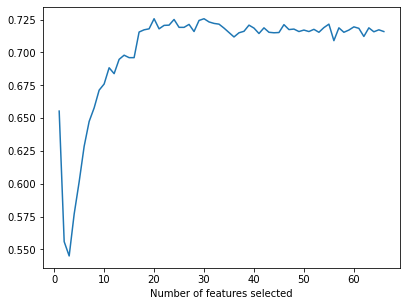

In [182]:
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),scoring='accuracy')
rfecv.fit(X, Y)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [183]:
rfecv.n_features_

30

In [184]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
dt3 = DecisionTreeClassifier()
dt3.fit(X_new, Y)
acc = dt3.score(Xt_new, Yt)
f1 = f1_score(Yt, dt3.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

F1 Score:  0.7357846438250734


####Random Forest

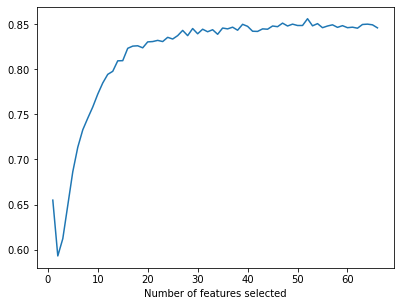

In [185]:
model = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),scoring='accuracy')
rfecv.fit(X, Y)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [143]:
rfecv.n_features_

47

In [186]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
rf3 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rf3.fit(X_new, Y)
acc = rf3.score(Xt_new, Yt)
f1 = f1_score(Yt, rf3.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

F1 Score:  0.8790234177845163


####KKN y Neural Network

KNN no expone la importancia de los features asi que no se puede analizar con RFECV y en las Neural Network tambien es complicado extraer esa informacion

###PCA

In [187]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [188]:
pca = PCA().fit(X)
pd.DataFrame(pca.components_, columns=X.columns).head()

,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,1.000000e+00,-0.000217,-8.997954e-10,-6.123243e-10,-8.622899e-10,5.426454e-11,-7.064144e-10,-4.808662e-11,-1.986817e-09,2.085782e-09,...,7.694008e-10,-2.599275e-10,6.338541e-11,5.349143e-10,7.584640e-10,5.124550e-10,1.290110e-09,-6.633042e-11,8.876720e-12,-7.708071e-10
1,2.167767e-04,1.000000,1.372858e-06,9.823313e-07,2.040908e-06,-5.886283e-07,1.099718e-06,1.152121e-06,4.042427e-06,-1.081897e-06,...,-3.684980e-07,-5.832639e-07,-5.996329e-07,-1.643323e-06,-1.328433e-06,-1.015457e-06,-2.036467e-06,8.787965e-08,4.372082e-10,1.779330e-06
2,3.427200e-09,-0.000002,2.312052e-01,-1.189575e-01,2.654411e-01,6.954521e-02,5.001155e-02,-1.878294e-01,-3.468286e-02,-2.269004e-01,...,-6.928826e-02,9.637842e-02,4.136360e-03,1.566943e-01,-1.694083e-01,1.634361e-01,-1.324815e-01,5.811747e-03,1.897264e-04,-1.964994e-02
3,2.796272e-09,-0.000007,-8.879713e-02,1.234609e-01,2.157285e-02,-1.181950e-01,8.258132e-02,1.844560e-01,5.402598e-01,-1.476042e-01,...,-7.435894e-02,-6.047210e-02,-4.861036e-02,-1.503875e-01,-1.059972e-01,-6.514157e-02,-2.139088e-01,9.956457e-03,-4.655072e-04,1.856384e-01
4,-1.584579e-09,-0.000003,3.068686e-01,-7.397583e-02,4.306761e-01,-6.307628e-02,-3.274904e-02,-1.280919e-02,-1.498475e-02,1.744453e-01,...,9.936162e-02,-8.649779e-02,-1.096673e-01,-1.640867e-01,-3.049115e-03,-1.249481e-01,-1.235799e-01,1.264567e-03,-2.185775e-03,9.947628e-02


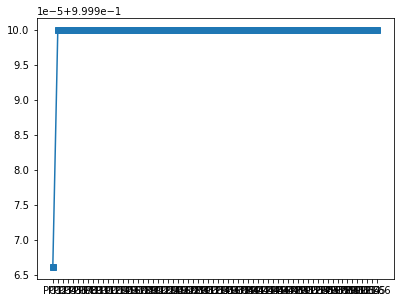

In [189]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=5)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.plot(labels, np.cumsum(pca.explained_variance_ratio_), '-s')
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#plt.rcParams['figure.figsize'] = 5, 60
plt.show()

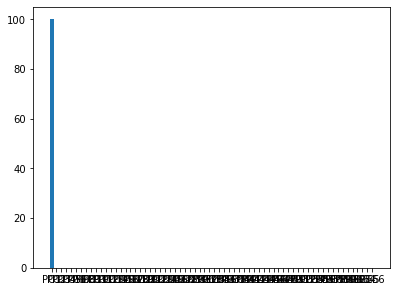

In [190]:
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label = labels)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

####Decision Tree

In [152]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  dt4 = DecisionTreeClassifier()
  dt4.fit(X_new, Y)
  acc = dt4.score(Xt_new, Yt)
  f1 = f1_score(Yt, dt4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

Score usando  1 componentes F1: 0.303253515823415  acurracy:  0.3012279355333845
Score usando  2 componentes F1: 0.6076113132478111  acurracy:  0.6051419800460476
Score usando  3 componentes F1: 0.5688603931325503  acurracy:  0.5660015349194167
Score usando  4 componentes F1: 0.5964194151294303  acurracy:  0.5943975441289332
Score usando  5 componentes F1: 0.6238853849015008  acurracy:  0.6231772831926324
Score usando  6 componentes F1: 0.6420456017462451  acurracy:  0.639293937068304
Score usando  7 componentes F1: 0.691210069777373  acurracy:  0.6884113584036838
Score usando  8 componentes F1: 0.703539741383714  acurracy:  0.70376055257099
Score usando  9 componentes F1: 0.7211679524487876  acurracy:  0.7217958557175749
Score usando  10 componentes F1: 0.7046334534836037  acurracy:  0.7045280122793554
Score usando  11 componentes F1: 0.7178119140816609  acurracy:  0.7164236377590176
Score usando  12 componentes F1: 0.7243956123628607  acurracy:  0.7229470452801228
Score usando  13 co

####Random Forest

In [153]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  rf4 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
  rf4.fit(X_new, Y)
  acc = rf4.score(Xt_new, Yt)
  f1 = f1_score(Yt, rf4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

Score usando  1 componentes F1: 0.30312360064782573  acurracy:  0.3012279355333845
Score usando  2 componentes F1: 0.5374689926532099  acurracy:  0.5502686108979279
Score usando  3 componentes F1: 0.584131286481295  acurracy:  0.5963161933998465
Score usando  4 componentes F1: 0.6539034464550199  acurracy:  0.6653875671527245
Score usando  5 componentes F1: 0.6874091447705099  acurracy:  0.6976208749040675
Score usando  6 componentes F1: 0.720734890746903  acurracy:  0.7302379125095932
Score usando  7 componentes F1: 0.760723863429117  acurracy:  0.7689946277820414
Score usando  8 componentes F1: 0.7828011179906654  acurracy:  0.7908672294704528
Score usando  9 componentes F1: 0.7920346869083209  acurracy:  0.7981580966999232
Score usando  10 componentes F1: 0.7993193284729563  acurracy:  0.8046815042210284
Score usando  11 componentes F1: 0.7969224855465957  acurracy:  0.8054489639293937
Score usando  12 componentes F1: 0.8166561570403198  acurracy:  0.8234842670759785
Score usando  1

####KNN

In [154]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  knn4 = KNeighborsClassifier(4)
  knn4.fit(X_new, Y)
  acc = knn4.score(Xt_new, Yt)
  f1 = f1_score(Yt, knn4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

Score usando  1 componentes F1: 0.31474295287105436  acurracy:  0.3215656178050652
Score usando  2 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  3 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  4 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  5 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  6 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  7 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  8 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  9 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  10 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  11 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  12 componentes F1: 0.446844532716066  acurracy:  0.4528012279355334
Score usando  13 compon